In [36]:
#!pip install torch
#!pip install transformers

In [37]:
from typing import Sequence
import torch

In [38]:
from transformers import AutoModelForCausalLM, AutoTokenizer
checkpoint = "HuggingFaceTB/SmolLM2-1.7B"
device = "cpu" # for GPU usage or "cpu" for CPU usage
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# for multiple GPUs install accelerate and do `model = AutoModelForCausalLM.from_pretrained(checkpoint, device_map="auto")`
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)
# inputs = tokenizer.encode("Transformer architecture is", return_tensors="pt").to(device)
# outputs = model.generate(inputs)
# print(tokenizer.decode(outputs[0]))

In [39]:
model.model.layers

ModuleList(
  (0-23): 24 x LlamaDecoderLayer(
    (self_attn): LlamaAttention(
      (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
      (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
      (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
      (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
    )
    (mlp): LlamaMLP(
      (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
      (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
      (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
      (act_fn): SiLU()
    )
    (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
    (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
  )
)

In [40]:
num_layers = len(model.model.layers)
num_layers

24

 The method for identifying super weights is based on the finding that super weights create super activations. Super activations are exceptionally massive activations observed in LLMs that persist across many layers, have constant magnitude, and always exist at the same position regardless of input. The activation's channel aligns with the super weight's channel, and the super activation first appears right after the super weight. Pruning the super weight drastically reduces the magnitude of this massive activation, suggesting a causal link.

Super weights can be located by detecting the spikes in the inputs and outputs distributions of the `mlp.down_proj` module across different layers. This detection process is efficient and requires only a single input prompt, not a full validation dataset. First, we need to save input and output activations for each layer:

In [41]:
model.get_submodule(f"model.layers.2.mlp.down_proj")

Linear(in_features=8192, out_features=2048, bias=False)

In [42]:
#lists to store inputs and outputs activations
all_inputs = []
all_outputs = []

# Register the hook for each layer
for i in range(num_layers):
    def save_activations_hook(module, inputs, outputs):
        if isinstance(inputs, Sequence):
            inputs = inputs[0]
        all_inputs.append(inputs.cpu())
        all_outputs.append(outputs.cpu())
    layer = model.get_submodule(f"model.layers.{i}.mlp.down_proj")
    layer.register_forward_hook(save_activations_hook)

In [49]:
with torch.no_grad():
    inputs = tokenizer.encode("Transformer architecture is", return_tensors="pt").to(device)
    outputs = model(inputs[:, :1])

In [50]:
len(all_inputs), len(all_outputs)

(24, 24)

Plot the extreme outliers in the input and output activations of the mlp.down_proj module for all transformer layers

In [51]:
max_input_activations = [inp_act.abs().max().item() for inp_act in all_inputs]
max_output_activations = [out_act.abs().max().item() for out_act in all_outputs]

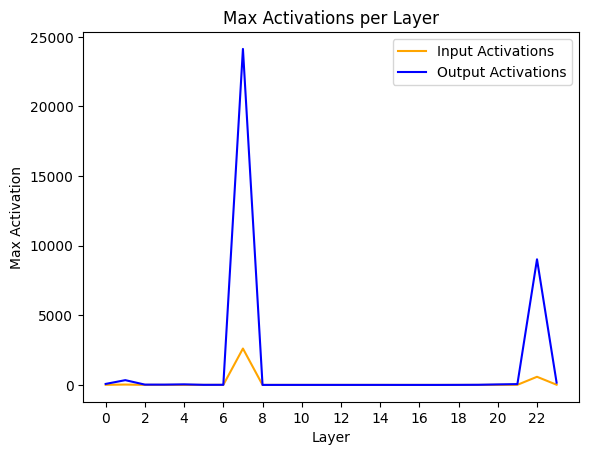

In [63]:
import matplotlib.pyplot as plt

plt.plot(max_input_activations, label="Input Activations", color="orange")
plt.plot(max_output_activations, label="Output Activations", color="blue")
plt.xlabel("Layer")
plt.ylabel("Max Activation")
plt.title("Max Activations per Layer")
plt.xticks(range(0, num_layers, 2))
plt.legend()
plt.show()

We can see that super activations first appear after layer 1 output So, the super weight must be in layer 1. Lets find it!

Specifically, for a given layer, the channel index of the large maximum-magnitude activation in the down_proj input indicates the row of the super weight.
The channel index of the large maximum-magnitude activation in the down_proj output in the same layer indicates the column of the super weight.

In [54]:
all_outputs[1].abs().max(dim=-1)

torch.return_types.max(
values=tensor([[342.2403]]),
indices=tensor([[749]]))

In [55]:
all_inputs[1].abs().max(dim=-1)

torch.return_types.max(
values=tensor([[26.4583]]),
indices=tensor([[4987]]))

So the super weight is [4987,749] of mlp down_proj from layer 1. Lets check that it actually is a super weight by looking at the activations it produces in each layer.

In [61]:
super_activations = [abs(act[0, -1, 749]) for act in all_outputs]


/tmp/ipykernel_344273/3639201231.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


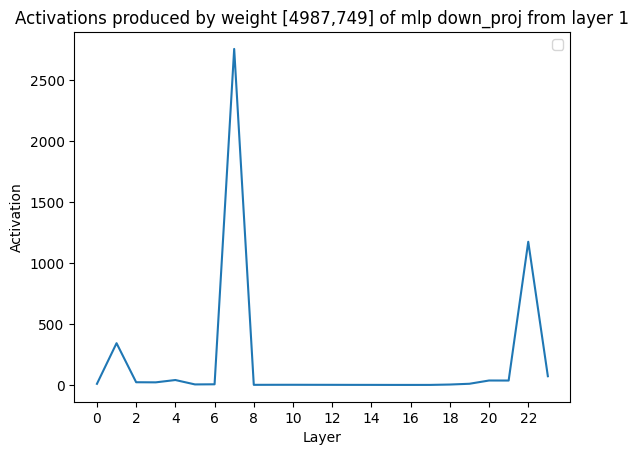

In [62]:
plt.plot(super_activations)
plt.xlabel("Layer")
plt.ylabel("Activation")
plt.title("Activations produced by weight [4987,749] of mlp down_proj from layer 1")
plt.xticks(range(0, num_layers, 2))
plt.legend()
plt.show()